## Imports

In [1]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# 🏆 Le Wagon Kaggle Batch Challenge

**Welcome to your first Kaggle competition!**

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

Your objective is to **submit an answer (online)** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 🏠

Fortunately, you have already come across the housing dataset earlier in the bootcamp! You will be semi-guided toward a **baseline model**, and only after creating a baseline will you be free to improve and refine it. We will approach the problem using **pipelines** (the best practice)!

A few words on Kaggle:
- Kaggle will rank your submission amongst all participants!
- Everyone is removed from the public leaderboard after 2 months
- You can make up to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- Collapse all headings from the command palette (`Cmd + Shift + P`)
- Stay  "idempotent" (`Restart & Run All` should never crash)
- Name and delete variables carefully

## Kaggle Setup

👉 Create an account on Kaggle if you want to participate in the competition

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` in the [results spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0); if you can't find your batch, reach out to your teacher!

**The whole batch will compete as a group against the team of TAs**

## Loading Data

In the challenge instructions, you should have already executed the steps to download everything you need from Kaggle into your current notebook folder:

- `train.csv` is your `(1460, 81)` training set containing `X` and `y`
- `test.csv` is your `(1459, 80)` testing set without the associated target `y` 😈
- `sample_submission.csv` describes the format required to submit your answer

ℹ️ You'll find a detailed description of the dataset [here](https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/07-Ensemble-Methods/kaggle_houses_data_description.txt). Refer to it throughout the challenge!

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your `test_score` and ranking

❓ Load the training dataset into a DataFrame called `data`, and create your `X` and `y`. Inspect their shapes.

**Hint:** if you check the CSV file, you will notice a column called `Id`. When reading the CSV file into a DF, make sure to set `index_col="Id"` so that you don't get two ID columns 😉

In [5]:
import pandas as pd

# Load training and test data
train = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv", index_col="Id")
test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv", index_col="Id")


# Separate features (X) and target (y) from the training set
X = train.drop(columns=["SalePrice"])
y = train["SalePrice"]

# Inspect shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Test shape: {test.shape}")


X shape: (1460, 79)
y shape: (1460,)
Test shape: (1459, 79)


# 🐣 1. BASELINE

## 1.1 Initial feature overview

79 features are too much to deal with one by one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [6]:
# Count numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

print(f"Number of numerical features: {len(num_features)}")
print(f"Number of categorical features: {len(cat_features)}")


Number of numerical features: 36
Number of categorical features: 43


❓ Create a Series called `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total?

In [8]:
# Number of unique values per categorical feature
feat_categorical_nunique = X[cat_features].nunique().sort_values()

feat_categorical_nunique.sum()


251

In [9]:
feat_categorical_nunique

Street            2
Alley             2
CentralAir        2
Utilities         2
MasVnrType        3
LandSlope         3
PoolQC            3
PavedDrive        3
GarageFinish      3
BsmtQual          4
ExterQual         4
KitchenQual       4
BsmtCond          4
BsmtExposure      4
Fence             4
MiscFeature       4
LandContour       4
LotShape          4
FireplaceQu       5
Electrical        5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
BldgType          5
ExterCond         5
BsmtFinType1      6
RoofStyle         6
GarageType        6
Foundation        6
Heating           6
BsmtFinType2      6
SaleCondition     6
Functional        7
RoofMatl          8
HouseStyle        8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with a maximum of ~50 features (📚 read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
1. **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model; this may require statistical analysis of feature importance
2. **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot encode) categorical features into integers; this, however, creates a notion of "order" (1 > 2 > 3 > ...) that can be detrimental if not handled properly!

❓ Plot the **histogram** of the number of unique values per categorical feature. Do you see some quick wins?

<Axes: >

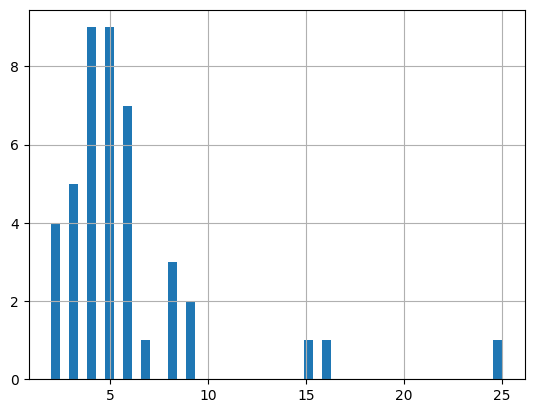

In [11]:
# Histogram
feat_categorical_nunique.hist(bins=50)


💡 As a starting point, what about simply **removing** all features that have **7 unique values or more**, and one-hot encoding the rest? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store the names of the features to be OHE'd in a list called `feat_categorical_small` below. How many features will be OHE'd?

In [12]:
# Filter small categorical features
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7].index.tolist()
len(feat_categorical_small)


34

In [ ]:
# YOUR CODE HERE

🧪 Test your code below (and clear the cell once it passed)

In [13]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'features_overview',
    n=len(feat_categorical_small)
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master



## 1.2 Baseline Pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features:
- Simple-Impute with the most frequent values
- One-Hot Encode features that have less than 7 unique values to start with
- Drop all other features


As for numerical features:
- Simple-Impute with strategy `mean`
- Min-Max Scale


<details>
    <summary>ℹ️ Click here for a pro tip</summary>

If you are confident, you can try Sklearn's shorter-syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax of `Pipeline` or `ColumnTransformer`; also useful if you want to avoid giving names manually to every step.
</details>

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# Numerical pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

# Categorical small pipeline
cat_small_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(drop="if_binary",handle_unknown="ignore"))
])

# Full preprocessing pipeline
preproc_baseline = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat_small", cat_small_pipe, feat_categorical_small)
], remainder="drop")  # drop the large categorical features for now

# Fit + transform
X_preproc_baseline = preproc_baseline.fit_transform(X)

# Store shape for test
shape_preproc_baseline = X_preproc_baseline.shape



❓ Look at the **shape** of your preprocessed DataFrame and save it to `shape_preproc_baseline`

In [18]:
shape_preproc_baseline

(1460, 178)

🧪 Test your code below

In [19]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED         [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master



### b) Add Estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [20]:


pipe_baseline = Pipeline([
    ("preproc", preproc_baseline),
    ("model", DecisionTreeRegressor(random_state=42))
])


### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Which performance metric do you need? Is it readily available in Sklearn?

Sadly, it isn't! We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search. The process is described below:


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [21]:
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_val_score
import numpy as np

# Create RMSLE scorer
def rmsle_func(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle = make_scorer(rmsle_func, greater_is_better=False)

# Cross-validate
cv_scores = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)

# Store the baseline score
score_baseline = -cv_scores.mean()  # negate because we set greater_is_better=False
score_baseline


/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [19, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during

0.20815285547574822

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [ ]:
# YOUR CODE HERE

### d) Predict Baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [23]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict SalePrice using the baseline pipeline
pipe_baseline.fit(X, y)
y_pred_baseline = pipe_baseline.predict(X_test)

❓ Finally, store your ready-to-submit CSV as `submission_baseline.csv` in the `data` folder. **Carefully read** and understand Kaggle's required format and test it below (you don't need to submit this baseline to Kaggle for now).

In [24]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,129000.0


In [25]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("data/submission_baseline.csv", header=True, index=False)

🧪 Test your code

In [26]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 4 items

test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.11s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push origin maste

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation on having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

Now, your goal is to improve your prediction and submit it to Kaggle **at least 30 minutes before the Recap ⏳**

We have some suggestions for improvements below: **pick your battles** and **incrementally** improve your pipeline as you see fit!

**Estimators**

- Tree-based ensembles (a must-try today); probably the best suited for problems with many categorical features
- Stacking!
- XGBoost!

**Preprocessing** (once your first ensemble model works)

- **Ordinal Encoding** of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- **Statistical Feature Selection** to remove useless features (avoids overfitting and reduces training time)
- Predict `log(SalePrice)` instead?
- 🤷

In [36]:


models = {
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(),
    "XGBoost" : XGBRegressor ( random_state =42),
    "LinearRegression" : LinearRegression (),
    "BaggingTree" : BaggingRegressor (random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR" : SVR()

}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preproc", preproc_baseline),
        ("model", model)
    ])
    cv = cross_val_score(pipe, X, y, cv=5, scoring=rmsle)
    results[name] = -cv.mean()

results

/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [19, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during

{'DecisionTree': 0.20815285547574822,
 'RandomForest': 0.14612795220895533,
 'GradientBoosting': 0.13219923406160877,
 'Ridge': 0.16593197951288996,
 'XGBoost': 0.1450229418590067,
 'LinearRegression': 0.19251960869253124,
 'BaggingTree': 0.1531042135664888,
 'KNN': 0.21751435829931376,
 'SVR': 0.3994264668099439}

In [38]:
sorted_results = dict(sorted(results.items(), key=lambda x: x[1]))
top5 = dict(list(sorted_results.items())[:5])
top5


{'GradientBoosting': 0.13219923406160877,
 'XGBoost': 0.1450229418590067,
 'RandomForest': 0.14612795220895533,
 'BaggingTree': 0.1531042135664888,
 'Ridge': 0.16593197951288996}

In [39]:
#randomSearchCV pour gradient boosting
Best RMSLE: 0.1281

param_dist = {
    "model__n_estimators": np.arange(200, 2001, 200), #nombre d’arbres (le meilleur : 2000)
    "model__learning_rate": np.linspace(0.01, 0.2, 10), #vitesse d’apprentissage (le meilleur : 0,01 = vitesse lente)
    "model__max_depth": np.arange(2, 7), #profondeur des arbres (le meilleur : 5)
    "model__subsample": np.linspace(0.5, 1.0, 6), # (le meilleur : 0,5)Prend 50% des samples à chaque arbre → réduit le surfit
    "model__min_samples_leaf": np.arange(1, 11), # minimum d'echantillon par feuille. pas de petites feuilles ( le meilleur = 10), lisse la prédiction
    "model__max_features": ["sqrt", None, 0.3, 0.5, 0.8] # limite le nb feature / split ( le meilleur : 50%)
}

pipe = Pipeline([
    ("preproc", preproc_baseline),
    ("model", GradientBoostingRegressor(random_state=42))
])

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=40,          # nombre d’essais 
    scoring=rmsle,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X, y)
print("Best RMSLE:", -random_search.best_score_)
print("Best params:", random_search.best_params_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [19, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during

Best RMSLE: 0.1281828940542629
Best params: {'model__subsample': 0.5, 'model__n_estimators': 2000, 'model__min_samples_leaf': 10, 'model__max_features': 0.5, 'model__max_depth': 5, 'model__learning_rate': 0.01}
[CV] END model__learning_rate=0.1788888888888889, model__max_depth=2, model__max_features=0.5, model__min_samples_leaf=3, model__n_estimators=1400, model__subsample=0.7; total time=   4.0s
[CV] END model__learning_rate=0.2, model__max_depth=5, model__max_features=0.8, model__min_samples_leaf=8, model__n_estimators=1600, model__subsample=1.0; total time=  19.5s
[CV] END model__learning_rate=0.1366666666666667, model__max_depth=6, model__max_features=0.3, model__min_samples_leaf=9, model__n_estimators=600, model__subsample=0.7; total time=   2.8s
[CV] END model__learning_rate=0.1577777777777778, model__max_depth=6, model__max_features=0.8, model__min_samples_leaf=8, model__n_estimators=2000, model__subsample=1.0; total time=  29.6s
[CV] END model__learning_rate=0.2, model__max_dep

In [41]:
# 2eme RandomSeach pour affiner gradient boosting
#Best RMSLE: 0.1277
# Best Params: {'model__subsample': 0.45, 'model__n_estimators': 2600, 'model__min_samples_leaf': 10, 'model__max_features': 0.4, 'model__max_depth': 4, 'model__learning_rate': 0.01}

param_dist_refined = {
    "model__n_estimators": np.arange(1800, 2800, 200),
    "model__learning_rate": [0.01],
    "model__max_depth": [4, 5, 6],
    "model__subsample": np.linspace(0.4, 0.6, 5),
    "model__min_samples_leaf": np.arange(10, 16),
    "model__max_features": np.linspace(0.4, 0.6, 5)
}

random_search_refined = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist_refined,
    n_iter=20,
    scoring=rmsle,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_refined.fit(X, y)
print("Best RMSLE:", -random_search_refined.best_score_)
print("Best Params:", random_search_refined.best_params_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 15, 28, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [19

Best RMSLE: 0.12775258083144828
Best Params: {'model__subsample': 0.45, 'model__n_estimators': 2600, 'model__min_samples_leaf': 10, 'model__max_features': 0.4, 'model__max_depth': 4, 'model__learning_rate': 0.01}


In [43]:
# Modele XGBoost avec randomSearch (2iterations)
#Best RMSLE: 0.12607121199515176
#Best params: {'model__subsample': 0.55, 'model__reg_lambda': 1.5, 'model__n_estimators': 1200, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__gamma': 0.2, 'model__colsample_bytree': 0.8}

param_dist_xgb = {
    "model__n_estimators": [800, 1000, 1200],
    "model__learning_rate": [0.01],
    "model__max_depth": [5, 6, 7],
    "model__subsample": [0.55, 0.6, 0.65],  # fractionnement
    "model__colsample_bytree": [0.7, 0.8, 0.9],  # fraction de colonnes
    "model__reg_lambda": [1.5, 2, 2.5],  # pénalisation L2 (ridge)
    "model__gamma": [0.1, 0.2, 0.3]  # régularisation des splits
}

xgb_pipe = Pipeline([
    ("preproc", preproc_baseline),
    ("model", XGBRegressor(
        objective='reg:squarederror',  # pour une régression type RMSE
        random_state=42,
        n_jobs=-1,
        tree_method="hist"  # optimal sur CPU si GPU non dispo
    ))
])

random_search_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist_xgb,
    n_iter=20,  # nombre d'échantillonnages aléatoires
    scoring=rmsle,  # ta fonction RMSLE custom
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_xgb.fit(X, y)

print("Best RMSLE:", -random_search_xgb.best_score_)
print("Best params:", random_search_xgb.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 15, 28, 31

Best RMSLE: 0.12607121199515176
Best params: {'model__subsample': 0.55, 'model__reg_lambda': 1.5, 'model__n_estimators': 1200, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__gamma': 0.2, 'model__colsample_bytree': 0.8}


## 2.1 Preprocessing Iteration ♲ 
**⚠️ Come back here only after you have iterated on your estimators in section 2.2 ⚠️**

⏩ Collapse me if I'm not in use!

### a) Ordinal Encoding (~1h)

In [47]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


In [48]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

❓ Look at the following feature. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that! Check it out below and make sure to understand how this works 👇

In [ ]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good']
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

In [49]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** (of your choice)
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort your features alphabetically to avoid bad surprises
</details>

In [52]:


# Définition des features ordinales avec leur ordre
feat_ordinal_dict = {
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys())  # Trier les features ordinales
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

# Pipeline pour les features ordinales
preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        dtype=np.int64,
        handle_unknown="use_encoded_value",
        unknown_value=-1  
    ),
    MinMaxScaler()  
)

# Pipeline pour les features nominales
feat_nominal = X.select_dtypes(include='object').columns.difference(feat_ordinal)

preproc_nominal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

#Pipeline pour les features numériques
num_features = X.select_dtypes(include=['int64', 'float64']).columns

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

# Pipeline complet
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("ordinal", preproc_ordinal, feat_ordinal),
        ("nominal", preproc_nominal, feat_nominal),
    ],
    remainder='drop'
)


# ✅ Fit + Transform example
X_preprocessed = preprocessor.fit_transform(X)


In [53]:
# Meilleur XGBoost avec hyperparamètres
best_xgb = Pipeline([
    ("preproc", preprocessor),
    ("model", XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        n_estimators=1200,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.55,
        colsample_bytree=0.8,
        reg_lambda=1.5,
        gamma=0.2
    ))
])

# Entraînement
best_xgb.fit(X, y)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea'...
                              feature_types=None, gamma=0.2, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1200, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [54]:
# Prédictions sur X_test
test_predictions = best_xgb.predict(X_test)



178942.84

### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features to limit overfitting and shorten training time.  

🔥 We will make use of Sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you try **only Option 1 today**, to start with. Options 2 and 3 will be corrected in the Recap!

#### Option 1 (Recommended) - <font color=green>Univariate</font> Feature Selection
*based on their mutual information with target `y`*

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter out features that, taken individually, least explain your target!
- The statistical test we recommend passing to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) is a **statistical** distance between two probability distributions
- Correlation is a **linear** distance between two random variables
- Mutual Information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [this animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [ ]:
# YOUR CODE HERE

#### Option 2 - <font color=green>Multivariate</font> Feature Selection
*based on their combined relationship with target `y`*

🤔 We want to remove features that do not help predict our target even when combined with all the others.

1️⃣ To do so, remember that we can use the [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove.

The best thing is that `scikit-learn` allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer; this will recursively remove the least important features according to the `cross_val_score`.

When you have many features, however, this process can take extremely long to train.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of `feature_importance` when being fitted. For instance, trees with a Gini-based `feature_importance_`, or Lasso regressions with an L1 `coef_`. `scikit-learn` already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [ ]:
# YOUR CODE HERE

#### Option 3 - <font color=green>Unsupervised</font> Selection?
*filter based only on the properties of `X`*

❓ A quick win is to remove features with the lowest variance. Think about it: a feature that only has one value is useless (and has a variance of 0).

Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline!

In [ ]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to visually check whether any **numerical** features almost entirely correlate with others
- Use `VIF` from `statsmodels` to check for features that have the highest multicollinearity

In [ ]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again.

In [ ]:
# YOUR CODE HERE

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold; you'll need a custom transformer class.

In [ ]:
# YOUR CODE HERE

### c) Treat Cyclical Features

❓ We have some time-based features, why not **transform them** into cyclical features?

🔎 If you want to know more about why and how we do this, go back to the `Preprocessing Workflow` challenge of the `Prepare the dataset` unit.

In [ ]:
# YOUR CODE HERE

### d) Target Engineering (~15min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`
- Normally distributed variables should be easier to predict with linear or parametric models
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

In [ ]:
# YOUR CODE HERE

## 2.2 Model Iteration ♻

#### a) Final Version of the Preproc Pipeline
❓We advise you to start with a fresh definition of your preprocessing pipeline below. Copy-paste from your existing code above.

This way you can quickly update it as needed and then try many model types to find the best one possible. You can try GridSearch (this could take a lot of time) or go model by model.

You can try one or more of the different models you learned in the previous units, and today. 

👉 Your goals:

  - **Try at least one linear model**
  
  - **Try at least one of the tree-based models** you discovered in this unit.

  - Compare the **cross-validated** scores of your different models.

  - It's also interesting to **compare how long it takes** to cross-validate the different models. 🔎 Add the `%%time` magic command as the first line of a notebook cell to time the execution of the cell.

In [ ]:
#OPTIMISATION DU PREPROCESSING


# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

It is time to discover your real test score by submitting to Kaggle! 

👉 Follow and complete the next steps to see how good your model is!

In [55]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

If you ran the optional cyclical feature treatment in 2.1, you will need to run the following cell to add the extra columns before you feed X_test into your pipeline.

In [ ]:
# If needed, add cyclical feature columns to X_test like we did to X
if 'months_in_a_year' in locals():
    # months_in_a_year is defined, so we need to add the cyclical features
    X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
    X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

    X_test.drop(columns=['MoSold'], inplace=True)

👉 Predict using your best estimator, and store the results in `predictions`.

In [56]:
predictions = best_xgb.predict(X_test)

👉 Run the following cells to prepare your predictions to submit to Kaggle.

In [57]:
# Create a DataFrame in the correct format
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,124012.703125
1,1462,158337.453125
2,1463,183853.921875
3,1464,190316.640625
4,1465,190994.906250
...,...,...
1454,2915,83559.500000
1455,2916,82421.437500
1456,2917,164408.421875
1457,2918,119267.343750


In [58]:
# Export to Kaggle format submission
results.to_csv("submission_final.csv", header=True, index=False)

👉 Go to Kaggle and submit your predictions. What is your test score? Compare it to the validation scores you obtained.

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)